# Before you start



1.   Upload "**CS470_P4**" directory we've submmited on your "**MyDrive**" directory in google drive.

2.   The directory contains pre-requisite data such as
  * whisper parameter pt file in ".cache/whisper"
  * audio
  * ground truth transcription
  * AWS_raw_output result

3. And then, just Run all thing!




# import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install spacy spacy-transformers
!python -m spacy download en_core_web_trf
!pip install pydub
!pip install git+https://github.com/openai/whisper.git
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.8/190.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.3 MB/s eta 0:00:00
2023-06-16 05:07:22.983915: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-16 05:07:23.038243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use avai

In [3]:
import os
import json
import pickle
from io import BytesIO
from tqdm import tqdm

In [4]:
from typing import Union, Optional
from pydantic import BaseModel, validator, Field
from typing import Callable, Any, Union, Iterable, Optional
import itertools

In [5]:
from pydub.silence import split_on_silence
from pydub import AudioSegment

In [6]:
import spacy, spacy_transformers
nlp = spacy.load('en_core_web_trf')

In [7]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
import whisper

#model = whisper.load_model("large-v1")
model = whisper.load_model("large-v1", download_root="/content/drive/MyDrive/CS470_P4/.cache/whisper")

100%|█████████████████████████████████████| 2.87G/2.87G [00:32<00:00, 95.3MiB/s]


# End-to-End Pipeline

Our End-to-End Whisper pipeline that is improved for Long Form Audio.
It consist of three steps.

1. Voice Activity Detection / Forced Alignment (with AWS ASR)
2. Pre-processing Audio
3. Run Whisper


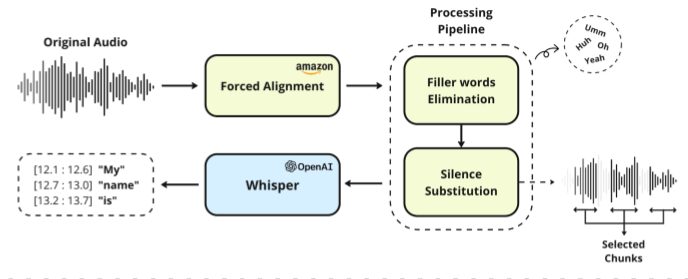


## Step 1. Voice Activity Detection / Forced Alignment (with AWS ASR)

Obtaining AWS ASR result is paid, so we've tried for 10 samples and saved them.
Therefore, this process is replaced with loading saved raw AWS ASR result from Google drive. For serving this model, we can make this function by using AWS ASR API.

In [9]:
def AWS_ASR_API(audio_path):
  pass

def run_AWS(audio_path, lid):
  '''
  Obtaining AWS ASR result is paid, so we've tried for 10 samples and saved them.
  Therefore, this process is replaced with loading saved raw AWS ASR result from Google drive.
  For serving this model, we can make this function by using AWS ASR API.

  Input
  audio : str
  lid : int

  Output
  AWS_raw_output : dictionary(json)
  '''
  AWS_ASR_API(audio_path)

  # Load ori_json_path.
  with open(f"/content/drive/MyDrive/CS470_P4/AWS_raw_output/{lid}.json", "rb") as f:
    AWS_raw_output = json.load(f)["results"]

  return AWS_raw_output

In [10]:
def tokens_to_corpus(contents):
  corpus = ""
  for i, item in enumerate(contents):
    if item["type"] == "pronunciation":
      corpus += ' ' + item["content"] if i != 0 else item["content"]
    else:
      corpus += item["content"]

  return corpus

def reorganization(item):
  # From raw AWS output form, remove "alternatives" key and take "confidence" and "content" key out.
  new_item = dict()
  for key, value in item.items():
    if key == "alternatives":
      assert(len(value) == 1)
      for k, v in value[0].items():
        new_item[k] = v

    else:
      new_item[key] = value

  return new_item

def is_filler(content):
  return content["content"].lower() in ["uh", "huh", "yeah", "mhm", "mm", "oh", "hmm", "ah", "um", "yep", "wow", "okay", "mm-hmm"]

def len_except_filler(turn):
  len = 0
  for content in turn["contents"]:
    if content["type"] != "punctuation" and not is_filler(content):
      len += 1

  return len

def turn_concat(turn1, turn2):
  # dst : turn1 // src : turn2
  assert(turn1["channel_label"] == turn2["channel_label"])
  turn1["contents"] += turn2["contents"]

  return turn1

def make_new_turns(turns):
  # Reorganize the turns.
  new_turns = []
  prev_ch = ""
  for turn in turns:
    if prev_ch == turn["channel_label"]:
      new_turns[-1] = turn_concat(new_turns[-1], turn)

    else:
      if len_except_filler(turn) > 3:
        if len(new_turns) > 0:
          new_turns[-1]["turn_corpus"] = tokens_to_corpus(new_turns[-1]["contents"])
        prev_ch = turn["channel_label"]
        new_turns.append(turn)

  return new_turns

def turns_sent_tokenize(turns):
  new_turns = []
  for turn in turns:
    sentences = sent_tokenize(turn["turn_corpus"])
    idxs = []
    start = 0
    for sent in sentences:
      sent_len = len(sent.replace(" ", ""))
      sum_content_len = 0
      for i, content in enumerate(turn["contents"][start:]):
        content = content["content"].replace(" ","")
        sum_content_len += len(content)
        assert sum_content_len <= sent_len, (sum_content_len, sent_len)
        if sum_content_len == sent_len:
          idxs.append((start, start+i+1))
          start += i+1
          break

    sents = []
    for s, (start, end) in zip(sentences, idxs):
      sent = dict()
      sent["contents"] = turn["contents"][start : end]
      assert(tokens_to_corpus(sent["contents"]) == s)
      sent["sent_corpus"] = s
      sents.append(sent)

    turn["sentences"] = sents
    turn.pop("contents")
    new_turns.append(turn)

  return new_turns

def q_insert(queue, content):
  if len(queue) == 4:
    queue.pop(-1)

  queue.insert(0, content)
  assert(len(queue) < 5)

def q_find(queue, content):
  q_contents = [content["content"].lower() for content in queue]
  try:
    return q_contents.index(content["content"].lower())
  except:
    return -1

def q_print(queue):
  for content in queue:
    print(content["content"])

  print()

def q_compare(q1, q2):
  assert len(q1) == len(q2), f"{q1}, {q2}"
  q1_contents = [content["content"].lower() for content in q1]
  q1_contents.reverse()
  q2_contents = [content["content"].lower() for content in q2]

  return q1_contents == q2_contents

def filler_tagging(turns):
  for turn in turns:
    for sentence in turn["sentences"]:
      for content in sentence["contents"]:
        if is_filler(content):
          content["type"] = "filler"

def n_gram_tagging(turns):
  padding = [{"content" : "\padding"}] * 4

  for turn in turns:
    for sentence in turn["sentences"]:
      new_contents = [content for content in sentence["contents"] if content["type"] == "pronunciation"]
      new_contents += padding
      queue = []
      i = 0
      while i < len(new_contents):
        content = new_contents[i]
        idx = q_find(queue, content)
        if idx == -1:
          q_insert(queue, content)
        else:
          if q_compare(queue[:idx+1], new_contents[i:i+idx+1]):
            for content in new_contents[i:i+idx+1]:
              content["type"] = "n-gram"
            i += idx

          else:
            q_insert(queue, content)

        i += 1

def punc_type_tagging(turns):
  for turn in turns:
    for sentence in turn["sentences"]:
      prev_type = ""
      for content in sentence["contents"]:
        if content["type"] == "punctuation":
          if prev_type == "filler" or prev_type == "n-gram":
            content["type"] = prev_type

        prev_type = content["type"]

def is_necessary_sent(sentence):
  c = [content for content in sentence["contents"] if content["type"] != "n-gram" and content["type"] != "filler" and content["type"] != "punctuation"]
  return len(c) > 3

def necessary_sent_tag(turns):
  for turn in turns:
    for sentence in turn["sentences"]:
      if is_necessary_sent(sentence):
        sentence["sent_type"] = "necessary"
      else:
        sentence["sent_type"] = "unnecessary"

def turn_time_stamp(turn):
  turn_start_time = None
  for content in turn["sentences"][0]["contents"]:
    try:
      turn_start_time = content["start_time"]
      break
    except:
      continue
  assert(turn_start_time != None)

  turn_end_time = None
  for i in range(1, len(turn["sentences"][-1]["contents"]) + 1):
    content = turn["sentences"][-1]["contents"][-i]
    try:
      turn_end_time = content["end_time"]
      break
    except:
      continue
  assert(turn_end_time != None)

  return (turn_start_time, turn_end_time)

def json_to_script(AWS_processed_output, lid):
  '''
  Conver AWS_processed_output into script format.
  '''
  turns = AWS_processed_output.copy()

  text = ""
  for turn in turns:
    turn_start_time, turn_end_time = turn_time_stamp(turn)
    text += turn["channel_label"] + f"({turn_start_time}, {turn_end_time})" '\n'
    for i, sen in enumerate(turn["sentences"]):
      text += " " + sen["sent_corpus"] if i != 0 else sen["sent_corpus"]

    text += '\n\n'

  with open(f"/content/drive/MyDrive/CS470_P4/{lid}/{lid}_AWS_processed_script.txt", "w", encoding="utf-8") as f:
    f.write(text)

  return

def preprocess_AWS_raw_output(AWS_raw_output, lid):
  '''
  The raw AWR ASR output in .json format is not well organize.
  Also, we require the timestamp information for each word particularly filler words.
  Therefore, it is necessary to reorganize the structure and label each word as a filler or non-filler.

  Input
  AWS_raw_output : dictionary(json)
  lid : int

  Output
  AWS_processed_output : dictionary(json)
  '''
  # Reorganize the structure of AWS_raw_output
  turns = []
  turn  = {"channel_label" : "", "contents" : []}
  prev_end_time = None
  for item in AWS_raw_output["items"]:
    item = reorganization(item)
    if item["type"] == "punctuation":
      item["start_time"] = prev_end_time
      item["end_time"] = prev_end_time
    elif item["type"] == "pronunciation":
      prev_end_time = item["end_time"]
    else:
      assert(0)

    if item["channel_label"] != turn["channel_label"]:
      if len(turn["contents"]) > 0:
        turn["turn_corpus"] = tokens_to_corpus(turn["contents"])
        turns.append(turn)
      turn = {"channel_label" : item["channel_label"], "contents" : []}

    turn["contents"].append(item)

  # Segment conversation between two speakrs into "turn"s.
  AWS_processed_output = make_new_turns(turns)

  # Segment "turn" into "sentence"s.
  AWS_processed_output = turns_sent_tokenize(AWS_processed_output)

  # Tag filler word and repetited n-gram.
  filler_tagging(AWS_processed_output)
  n_gram_tagging(AWS_processed_output)
  punc_type_tagging(AWS_processed_output)

  # Tag whether a sentnece is necessary.
  necessary_sent_tag(AWS_processed_output)

  # Save the result of preprocessed output
  os.makedirs(f"/content/drive/MyDrive/CS470_P4/{lid}", exist_ok=True)
  with open(f"/content/drive/MyDrive/CS470_P4/{lid}/{lid}_AWS_processed_output.json", "w") as f:
    json.dump(AWS_processed_output, f)

  # Save json into scirpt
  json_to_script(AWS_processed_output, lid)

  return AWS_processed_output

## Step 2. Pre-processing Audio

Preprocess Audio, that is removing filler words in autio and substituting silence over 100ms into 250ms silence. We've got these variables by several experiments

In [11]:
def base_filter(target, func ):
  filtered, rest = [], []
  [filtered.append(e) if func(e) else rest.append(e) for e in target]
  return filtered, rest

def get_by_name(target, name):
  return target[name] if type(target) == dict else getattr(target, name)

def filter_contents(turn , func, return_rest=False):
  '''
  Filter sepecific content from the TURN
  '''
  filtered_array, rest_array = [], []
  for sent in turn['sentences']:
    filtered, rest = base_filter(get_by_name(sent, "contents"), func)
    filtered_array += filtered; rest_array += rest

  return (filtered_array, rest_array) if return_rest else filtered_array

def remove_filler(turn, original_audio):
  '''
  According to TURN information, remove filler words from ORIGINAL_AUDIO.
  Return turn audio that is removed filler words.
  '''
  filler_contents = [j for sub in [filter_contents(turn, lambda e: e['type']=='filler')] for j in sub]
  turn_start = float(turn['sentences'][0]['contents'][0]['start_time']) * 1000
  turn_end = float(turn['sentences'][-1]['contents'][-1]['end_time']) * 1000
  if len(filler_contents) > 0:
      audio_without_filler = []
      for i, filler in enumerate(filler_contents):
        start_second, end_second = turn_start if i == 0 else float(filler_contents[i-1]['end_time']) * 1000, float(filler['start_time']) * 1000
        audio_without_filler.append(original_audio[start_second:end_second])
      audio_without_filler.append(original_audio[float(filler_contents[-1]['end_time']) * 1000 : turn_end])
      filler_removed = sum(audio_without_filler)
  else:
    filler_removed = original_audio[turn_start:turn_end]

  return filler_removed

def substitute_silence(audio, min_silence_len, keep_silence):
  audio_chunks = split_on_silence(audio, min_silence_len=min_silence_len, silence_thresh=-45, keep_silence=keep_silence)

  # Case that all of the words are filler word that'll be removed.
  if len(audio_chunks) == 0:
    return None

  return sum(audio_chunks)

def preprocess_Audio(raw_audio_path, AWS_processed_output, lid, channel='ch_0', exp=3):
  '''
  Preprocess Audio, that is removing filler words in autio and
  substituting silence over 100ms into 250ms silence.

  Input
  raw_audio : str
  AWS_processed_output : dictionary(json)
  lid : int

  Output
  AWS_processed_output : dictionary(json)
  '''
  if not (channel == 'ch_0' or channel == 'ch_1'):
    raise ValueError("preprocess_Audio() : Invalid channel : " + channel)

  if not exp in [0,1,2,3]:
    raise ValueError("preprocess_Audio() : Invalid exp : ", exp)

  if exp == 0:
    return raw_audio_path

  # Read audio data from .mp3 file.
  raw_audio = AudioSegment.from_mp3(raw_audio_path)

  # Take information in AWS_processed_output.
  turns, _ = base_filter(AWS_processed_output, lambda x: x['channel_label'] == channel)

  # Preprocess the Audio.
  processed_audio = AudioSegment.empty()
  for idx, turn in enumerate(turns):
    if exp == 1:
      output = remove_filler(turn, raw_audio)

    elif exp == 2:
      turn_start = float(turn['sentences'][0]['contents'][0]['start_time']) * 1000
      turn_end = float(turn['sentences'][-1]['contents'][-1]['end_time']) * 1000
      output = raw_audio[turn_start:turn_end]
      output = substitute_silence(output, 100, 250)

    elif exp == 3:
      output = remove_filler(turn, raw_audio)
      output = substitute_silence(output, 100, 250)

    else: assert(0)

    processed_audio += output

  # Save the preprocessed auido for logging.
  processed_audio_path = f"/content/drive/MyDrive/CS470_P4/{lid}/{lid}_processed_audio_exp_{exp}.mp3"
  processed_audio.export(processed_audio_path, format="mp3")

  return processed_audio_path

## Run Whisper

In [12]:
def run_Whisper(audio_path, lid, exp=3):
  if not exp in [0,1,2,3]:
    raise ValueError("preprocess_Audio() : Invalid exp : ", exp)

  whisper_result = model.transcribe(audio_path, language="en", fp16=True, initial_prompt="Hello, welcome to my lecture.",
                                    task="transcribe", verbose=True, temperature=0, best_of=5, beam_size=5, suppress_tokens="-1",
                                    condition_on_previous_text=True, compression_ratio_threshold=2.4,
                                    logprob_threshold=-1.0, no_speech_threshold=0.6)

  with open(f"/content/drive/MyDrive/CS470_P4/{lid}/{lid}_whisper_result_exp_{exp}.pickle", 'wb') as f:
    pickle.dump(whisper_result, f, pickle.HIGHEST_PROTOCOL)

  return whisper_result['text']

## End-to-end pipeline

In [13]:
def end_to_end_pipeline(audio_path, lid, exp=3):
  AWS_raw_output = run_AWS(audio_path, lid)
  AWS_processed_output = preprocess_AWS_raw_output(AWS_raw_output, lid)
  processed_audio = preprocess_Audio(audio_path, AWS_processed_output, lid, exp=exp)
  text = run_Whisper(processed_audio, lid, exp=exp)
  return text

In [14]:
lid = 840091
text = end_to_end_pipeline(f"/content/drive/MyDrive/CS470_P4/audio/student/{lid}_STUDENT.mp3", lid)

[00:00.000 --> 00:03.040]  Yes, I can hear you, can you hear me?
[00:03.040 --> 00:07.200]  By the way, it seems that the connection seems really,
[00:07.200 --> 00:12.200]  indeed not good, but let me try, let me just try.
[00:14.200 --> 00:18.360]  Sometimes, my name is Chan Ho Sung.
[00:18.360 --> 00:23.360]  I'm a software engineer working for SAP.
[00:23.360 --> 00:26.680]  I'm not sure if you know SAP.
[00:26.680 --> 00:31.160]  SAP is a Germany-based global software company,
[00:31.160 --> 00:35.000]  which is number one in ERP area.
[00:35.000 --> 00:39.680]  ERP is enterprise resource planning software.
[00:39.680 --> 00:44.680]  Every company use ERP for managing all of their business
[00:46.840 --> 00:50.800]  from manufacturing, supply,
[00:50.800 --> 00:53.960]  and their human resource and so on.
[00:53.960 --> 00:58.040]  So everything is being managed by ERP.
[00:59.160 --> 01:03.600]  Because of my work, I have to work with colleagues abroad,
[01:03.600 --> 01:05.720] 

In [15]:
text

" Yes, I can hear you, can you hear me? By the way, it seems that the connection seems really, indeed not good, but let me try, let me just try. Sometimes, my name is Chan Ho Sung. I'm a software engineer working for SAP. I'm not sure if you know SAP. SAP is a Germany-based global software company, which is number one in ERP area. ERP is enterprise resource planning software. Every company use ERP for managing all of their business from manufacturing, supply, and their human resource and so on. So everything is being managed by ERP. Because of my work, I have to work with colleagues abroad, especially in Germany. I know many German colleagues and friends because SAP is Germany-based. And also, I have to work with many colleagues all over the world, including United States. So practicing English is needed for my work. And also, I just want to improve my English because everything, nearly everything, every verb is written in English nowadays. And the reason why I picked this topic is tha

# Measurement Tools
Tools for calculating WER stands for Word Error Rate

In [16]:
from whisper import normalizers
import jiwer

In [17]:
etn = normalizers.EnglishTextNormalizer()
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.Strip(),
    jiwer.ExpandCommonEnglishContractions(),
])

In [18]:
def is_filler_token(token):
  COMBINATIONS = ['uh', 'uh.', 'uh,', 'uh?', 'uh!', 'huh', 'huh.', 'huh,', 'huh?', 'huh!', 'yeah', 'yeah.', 'yeah,', 'yeah?', 'yeah!', 'mmh','mmh.','mmh,','mmh?','mhm!', 'mhm.', 'mhm,', 'mhm?', 'mhm!', 'mm', 'mm.', 'mm,', 'mm?', 'mm!', 'oh', 'oh.', 'oh,', 'oh?', 'oh!', 'hmm', 'hmm.', 'hmm,', 'hmm?', 'hmm!', 'ah', 'ah.', 'ah,', 'ah?', 'ah!', 'um', 'um.', 'um,', 'um?', 'um!', 'yep', 'yep.', 'yep,', 'yep?', 'yep!', 'wow', 'wow.', 'wow,', 'wow?', 'wow!', 'okay', 'okay.', 'okay,', 'okay?', 'okay!', 'mm-hmm', 'mm-hmm.', 'mm-hmm,', 'mm-hmm?', 'mm-hmm!', '...', '....', '...,', '...?', '...!', '[inaudible]', '[inaudible].', '[inaudible],', '[inaudible]?', '[inaudible]!', '[laughs]', '[laughs].', '[laughs],', '[laughs]?', '[laughs]!', '[laughing]', '[laughing].', '[laughing],', '[laughing]?', '[laughing]!']
  return token in COMBINATIONS

def filler_remove(sents):
  tokens =[token for token in sents.split() if not is_filler_token(token.lower())]
  return " ".join(tokens) if len(tokens) > 0 else ""

def preprocessing(sents):
  sents = etn(sents)
  sents = transformation(sents)
  result_sents = filler_remove(sents)
  return result_sents

In [19]:
def get_ground_truth(lid, channel="ch_0"):
  '''
  Get ground truth transcription that is transcribed by human.
  Original ground truth transcriptions is form like below,
  so we need to extract the CHANNEL part from it.

  [Original ground truth]
  ch_1 : Hello.
  ch_0 : Hi.
  ch_1 : Nice to meet you.
  ch_0 : How are you?

  [Output of get_ground_truth(lid, ch_0)]
  Hi. How are you?

  Input
  lid : int
  channel : str

  Output
  ground_truth : str
  '''
  if not(channel == "ch_0" or channel == "ch_1"):
    raise ValueError('Invalid channel : '+ channel)

  with open(f"/content/drive/MyDrive/CS470_P4/ground_truth/{lid}_rev_revised.txt", 'r+', encoding="utf-8") as f:
    lines = f.readlines()

  ground_truth = ""
  for line in lines:
    if line[:4] == channel:
      ground_truth += line[7:].replace('\n', '')

  return ground_truth

def get_hypothesis(lid, exp=3):
  '''
  Get hypothesis transcription that is transcribed by our ene-to-end model.

  Input
  lid : int

  Output
  hypothesis : str
  '''

  with open(f"/content/drive/MyDrive/CS470_P4/{lid}/{lid}_whisper_result_exp_{exp}.pickle", 'rb') as f:
    hypothesis = pickle.load(f)['text']

  return hypothesis

def measure_wer(ground_truth, hypothesis):
  return jiwer.wer(preprocessing(ground_truth), preprocessing(hypothesis))

In [21]:
lid = 840091
ground_truth = get_ground_truth(lid)
hypothesis = get_hypothesis(lid)
measure_wer(ground_truth, hypothesis)

0.14890510948905109

In [22]:
preprocessing(ground_truth)

'yes i can you can you hear me by the way it seems that the connection seems really indeed not good but by me but let me just give a try sometimes my name is chana hong i am a software engineer working for sap i am not sure if you know sap sap is a germany based global software company which is number one in erp area erp is enterprise resource planning software every company use erp for managing all all of their business from manufacturing or supply and their human resource and so on so everything is being managed by erp because of my work i have to work with colleagues abroad especially in germany i know many german colleagues and friends because sap is germany based and also i have to work with many colleagues all over the world including united states so practicing english is needed for my work and also i just want to improve my english because everything everything nearly everything valuable is written in english nowadays sounds good and the reason why i picked this topic is that y

# Experiment

**Compare four audio preprocessing methods explained below.**


exp 0. (hypothesis) using original Whisper without audio preprocessing

exp 1. filler remove : remove audio chunks matched with all of filler words based on AWS ASR result.

exp 2. silence substitute : silence over 100ms are substituted into 250ms silence(100ms and 250ms are found by many experiments.)

exp 3. filler remove + silence substitute

**Result**

The result of the 4 experiments can be shown below.

The numbers represent WER(Word Error Rate) and red boxes mean the result description occurs degeneration such as corpus repetition what we've mentioned in our poster. You can directly see the corpus repetition symptoms through below output text.

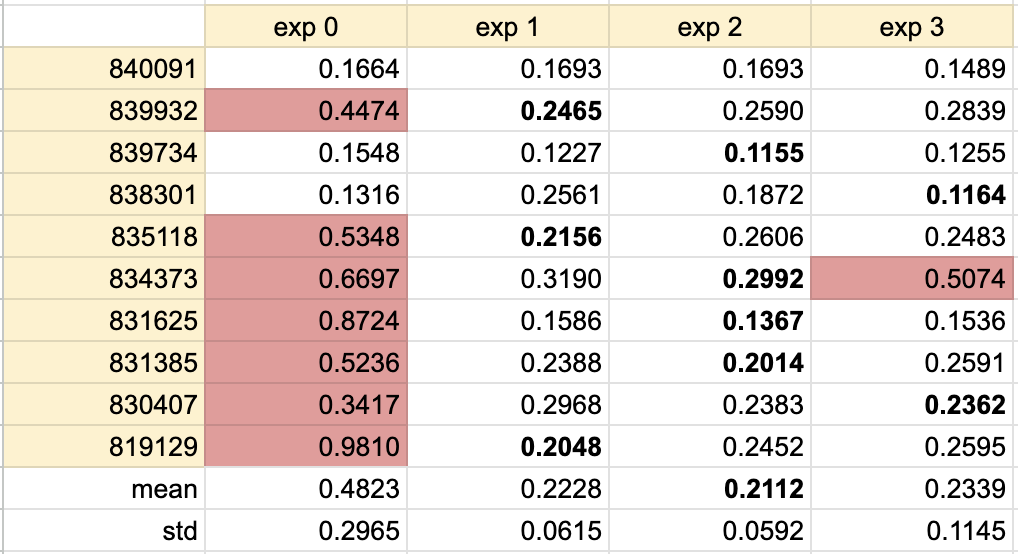

**Conclusion**

In the pre-processing process, long-form audio transcription accuracy was largely improved by removing filler words and silences that interfere with the process of moving context windows to process long-form audio. Given all these facts, we can conclude that audio processing using time-related information has a significant impact on the performance improvement of the ASR model.

After all, since it has been shown in Table 2 that strategy most effectively lowers WER varies for each audio, we leave designing a model equipped with preprocessing techniques based on unique characteristics for each audio as a  future work.

In [24]:
sample_ids = [840091, 839932, 839734, 838301, 835118, 834373, 831625, 831385, 830407, 819129]

exp 0. (hypothesis) using original Whisper without any audio preprocessing.

In [25]:
for lid in sample_ids:
  print(lid)
  end_to_end_pipeline(f"/content/drive/MyDrive/CS470_P4/audio/student/{lid}_STUDENT.mp3", lid, exp=0)

840091
[00:00.000 --> 00:28.000]  Thank you for joining us.
[00:29.000 --> 00:55.000]  Yes, I can hear you. Can you hear me?
[00:55.000 --> 01:19.000]  Okay.
[01:19.000 --> 01:30.000]  Mm hmm.
[01:30.000 --> 01:55.000]  Uh huh.
[01:55.000 --> 02:15.000]  Yeah, by the way, it seems that the connection things are really indeed not good, but let me try. Let me just give a try.
[02:15.000 --> 02:40.000]  Sometimes.
[02:40.000 --> 02:44.000]  Bye.
[02:44.000 --> 02:49.000]  Okay.
[02:49.000 --> 02:58.000]  My name is a tunnel song. I'm a software engineer, working for SAP.
[02:58.000 --> 03:04.000]  I'm not sure if you know SAP.
[03:04.000 --> 03:25.000]  SAP is a Germany based global software company, which is number one in erp area erp is enterprise resource planning software. Every company use erp for managing.
[03:25.000 --> 03:54.000]  All all about their business from manufacturing supply and their human resource and so on. So everything is being managed by erp.
[03:54.000 --> 04:09.0

exp 0. Measure WER

In [26]:
for lid in sample_ids:
  wer = measure_wer(get_ground_truth(lid), get_hypothesis(lid, exp=0))
  print(lid, wer)

840091 0.310948905109489
839932 0.7520775623268698
839734 0.8720651653090561
838301 0.1293800539083558
835118 0.5525238744884038
834373 0.5553987297106563
831625 0.24567000911577028
831385 0.4094536525475752
830407 0.3485364193328795
819129 0.8547619047619047


exp 1. filler remove

In [ ]:
for lid in sample_ids:
  print(lid)
  end_to_end_pipeline(f"/content/drive/MyDrive/CS470_P4/audio/student/{lid}_STUDENT.mp3", lid, exp=1)

840091
[00:00.000 --> 00:01.340]  Yes, I can hear you.
[00:01.340 --> 00:02.240]  Can you hear me?
[00:03.760 --> 00:07.880]  By the way, it seems that the connection seems really,
[00:07.880 --> 00:12.880]  indeed not good, but let me try and we just will try.
[00:21.560 --> 00:26.560]  Sometimes, my name is Chan Ho Sung.
[00:26.880 --> 00:31.420]  I'm a software engineer working for SAP.
[00:33.160 --> 00:36.480]  I'm not sure if you know SAP.
[00:36.480 --> 00:41.080]  SAP is a Germany-based global software company,
[00:41.080 --> 00:44.940]  which is number one in ERP area.
[00:44.940 --> 00:49.940]  ERP is enterprise resource planning software.
[00:50.600 --> 00:54.520]  Every company use ERP for managing


exp 1. Measure WER

In [ ]:
for lid in sample_ids:
  wer = measure_wer(get_ground_truth(lid), get_hypothesis(lid, exp=1))
  print(lid, wer)

exp 2. silence substitute

In [ ]:
for lid in sample_ids:
  print(lid)
  end_to_end_pipeline(f"/content/drive/MyDrive/CS470_P4/audio/student/{lid}_STUDENT.mp3", lid, exp=2)

exp 2. Measure WER

In [ ]:
for lid in sample_ids:
  wer = measure_wer(get_ground_truth(lid), get_hypothesis(lid, exp=2))
  print(lid, wer)

exp 3. filler remove + silence substitute

In [ ]:
for lid in sample_ids:
  print(lid)
  end_to_end_pipeline(f"/content/drive/MyDrive/CS470_P4/audio/student/{lid}_STUDENT.mp3", lid, exp=3)

exp 3. Measure WER

In [ ]:
for lid in sample_ids:
  wer = measure_wer(get_ground_truth(lid), get_hypothesis(lid, exp=3))
  print(lid, wer)